In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Importing Libraries

In [23]:
import os
import numpy as np
import pandas as pd
from PIL import Image
from glob import glob
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt

from imblearn.over_sampling import SMOTE
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from sklearn.model_selection import StratifiedKFold, train_test_split

import keras
import tensorflow as tf
from keras.optimizers import Adam
from keras.models import Sequential
from keras.preprocessing import image
from keras.utils import to_categorical
from tensorflow.python.client import device_lib
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D

In [3]:
# Set seed for reproducibility
np.random.seed(42)

# Loading Metadata

In [4]:
skin_df = pd.read_csv('/content/drive/MyDrive/H10K-Dataset/HAM10000_metadata.csv')
print(skin_df)

         lesion_id      image_id     dx dx_type   age     sex localization
0      HAM_0000118  ISIC_0027419    bkl   histo  80.0    male        scalp
1      HAM_0000118  ISIC_0025030    bkl   histo  80.0    male        scalp
2      HAM_0002730  ISIC_0026769    bkl   histo  80.0    male        scalp
3      HAM_0002730  ISIC_0025661    bkl   histo  80.0    male        scalp
4      HAM_0001466  ISIC_0031633    bkl   histo  75.0    male          ear
...            ...           ...    ...     ...   ...     ...          ...
10010  HAM_0002867  ISIC_0033084  akiec   histo  40.0    male      abdomen
10011  HAM_0002867  ISIC_0033550  akiec   histo  40.0    male      abdomen
10012  HAM_0002867  ISIC_0033536  akiec   histo  40.0    male      abdomen
10013  HAM_0000239  ISIC_0032854  akiec   histo  80.0    male         face
10014  HAM_0003521  ISIC_0032258    mel   histo  70.0  female         back

[10015 rows x 7 columns]


# Encode Labels

In [5]:
label_encoder = LabelEncoder()
label_encoder.fit(skin_df['dx'])
print(list(label_encoder.classes_))

skin_df['label'] = label_encoder.transform(skin_df["dx"])
print(skin_df.sample(10))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
        lesion_id      image_id   dx    dx_type   age     sex  \
1617  HAM_0007180  ISIC_0033272  mel      histo  65.0    male   
8128  HAM_0007195  ISIC_0031923   nv      histo  40.0  female   
2168  HAM_0001835  ISIC_0026652  mel      histo  65.0    male   
1090  HAM_0000465  ISIC_0030583  bkl  consensus  35.0  female   
7754  HAM_0001720  ISIC_0034010   nv      histo  45.0    male   
8071  HAM_0006333  ISIC_0024424   nv      histo  35.0    male   
7423  HAM_0004548  ISIC_0032832   nv      histo  45.0  female   
8984  HAM_0006526  ISIC_0026671   nv      histo  55.0    male   
2310  HAM_0003102  ISIC_0032389  mel      histo  65.0    male   
7256  HAM_0004260  ISIC_0025525   nv      histo  65.0    male   

         localization  label  
1617             face      4  
8128  lower extremity      5  
2168             back      4  
1090            trunk      2  
7754          abdomen      5  
8071            trunk      5  
7423  upper extr

In [6]:
# Check Class Distribution
print(skin_df['label'].value_counts())

label
5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: count, dtype: int64


# Loading Images

In [7]:
image_path = {os.path.splitext(os.path.basename(x))[0]:
              x for x in glob(os.path.join('/content/drive/MyDrive/H10K-Dataset/', '*', '*.jpg'))}

In [8]:
IMG_SIZE = 32

In [9]:
skin_df['path'] = skin_df['image_id'].map(image_path.get)
skin_df['image'] = skin_df['path'].map(lambda x: np.asarray(Image.open(x).resize((IMG_SIZE,IMG_SIZE))))

# Normalize Data

In [10]:
X = np.asarray(skin_df['image'].tolist())
X = X / 255.0

In [11]:
# Assign labels to Y variable
Y = skin_df['label']
Y_cat = to_categorical(Y, num_classes=7)

# Split data into train/validation and test sets

In [14]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y_cat, test_size=0.2, random_state=42, stratify=Y)

# Define Models

In [15]:
def create_model():
    model = Sequential()
    model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(IMG_SIZE, IMG_SIZE, 3)))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))

    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPool2D(pool_size=(2, 2)))
    model.add(Dropout(0.3))
    model.add(Flatten())

    model.add(Dense(32))
    model.add(Dense(7, activation='softmax'))

    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc'])

    return model

‎

‎

‎

# Method 1 (Augmentation)

## K-Fold Cross Validation

Fold 1
Epoch 1/200
401/401 [==============================] - 14s 22ms/step - loss: 1.1058 - acc: 0.6666 - val_loss: 1.0307 - val_acc: 0.6694
Epoch 2/200
  5/401 [..............................] - ETA: 5s - loss: 0.9675 - acc: 0.7250 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - 6s 14ms/step - loss: 1.0187 - acc: 0.6692 - val_loss: 1.0016 - val_acc: 0.6694
Epoch 3/200
401/401 [==============================] - 8s 19ms/step - loss: 0.9923 - acc: 0.6695 - val_loss: 0.9991 - val_acc: 0.6694
Epoch 4/200
401/401 [==============================] - 6s 14ms/step - loss: 0.9625 - acc: 0.6698 - val_loss: 0.9591 - val_acc: 0.6687
Epoch 5/200
401/401 [==============================] - 6s 16ms/step - loss: 0.9337 - acc: 0.6683 - val_loss: 0.9803 - val_acc: 0.6563
Epoch 6/200
401/401 [==============================] - 6s 16ms/step - loss: 0.9103 - acc: 0.6670 - val_loss: 0.8979 - val_acc: 0.6687
Epoch 7/200
401/401 [==============================] - 7s 17ms/step - loss: 0.9022 - acc: 0.6681 - val_loss: 0.8847 - val_acc: 0.6719
Epoch 8/200
401/401 [==============================] - 8s 20ms/step - loss: 0.8827 - acc: 0.6675 - val_loss: 0.8909 - val_acc: 0.6706
Epoch 9/200
401/401 [==============================] - 6s 16ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


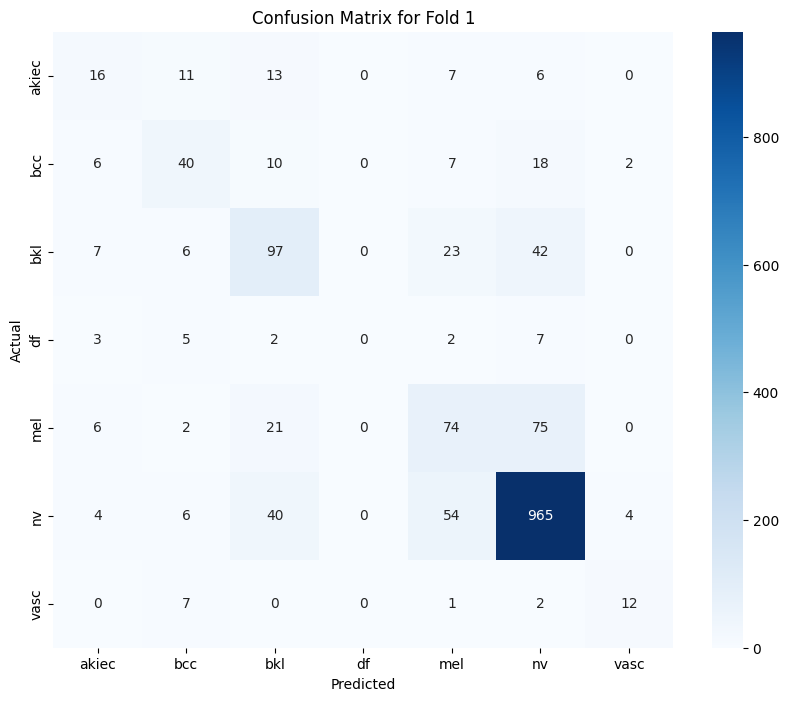

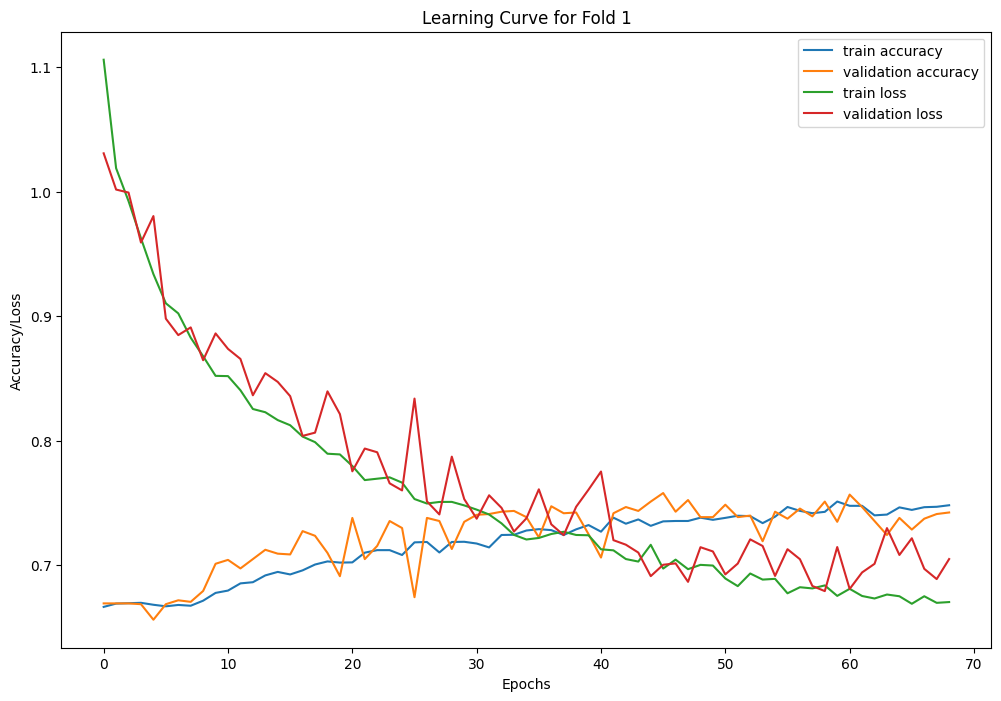

Fold 2
Epoch 1/200
401/401 [==============================] - 9s 18ms/step - loss: 1.1055 - acc: 0.6652 - val_loss: 1.0834 - val_acc: 0.6694


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
401/401 [==============================] - 6s 15ms/step - loss: 1.0154 - acc: 0.6697 - val_loss: 1.0104 - val_acc: 0.6694
Epoch 3/200
401/401 [==============================] - 6s 16ms/step - loss: 0.9922 - acc: 0.6689 - val_loss: 0.9771 - val_acc: 0.6694
Epoch 4/200
401/401 [==============================] - 7s 17ms/step - loss: 0.9495 - acc: 0.6694 - val_loss: 0.9699 - val_acc: 0.6463
Epoch 5/200
401/401 [==============================] - 6s 16ms/step - loss: 0.9141 - acc: 0.6663 - val_loss: 0.9126 - val_acc: 0.6619
Epoch 6/200
401/401 [==============================] - 6s 14ms/step - loss: 0.8982 - acc: 0.6678 - val_loss: 0.8754 - val_acc: 0.6700
Epoch 7/200
401/401 [==============================] - 7s 16ms/step - loss: 0.8842 - acc: 0.6725 - val_loss: 0.8683 - val_acc: 0.6744
Epoch 8/200
401/401 [==============================] - 8s 21ms/step - loss: 0.8690 - acc: 0.6733 - val_loss: 0.8523 - val_acc: 0.6613
Epoch 9/200
401/401 [==============================] - 6s 16ms

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


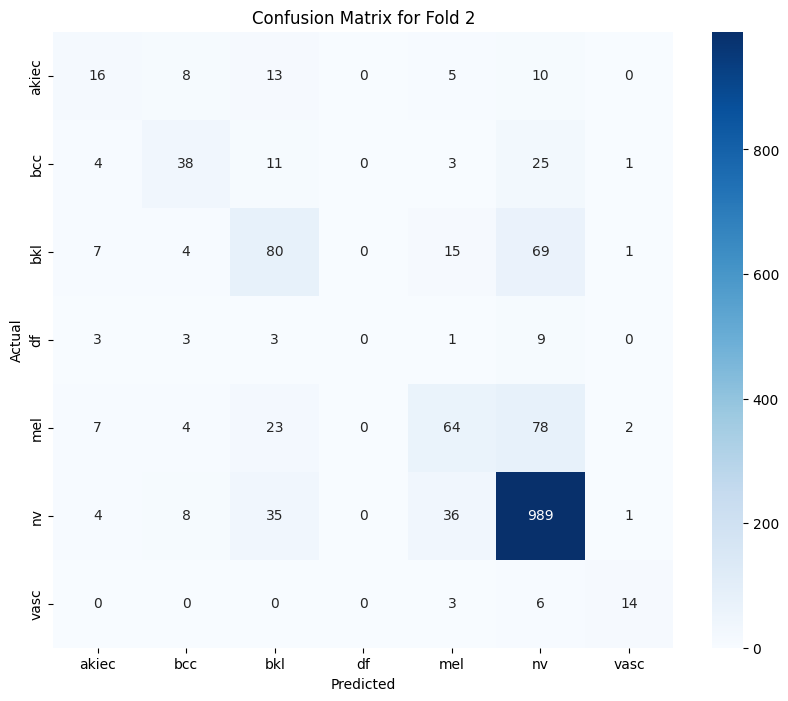

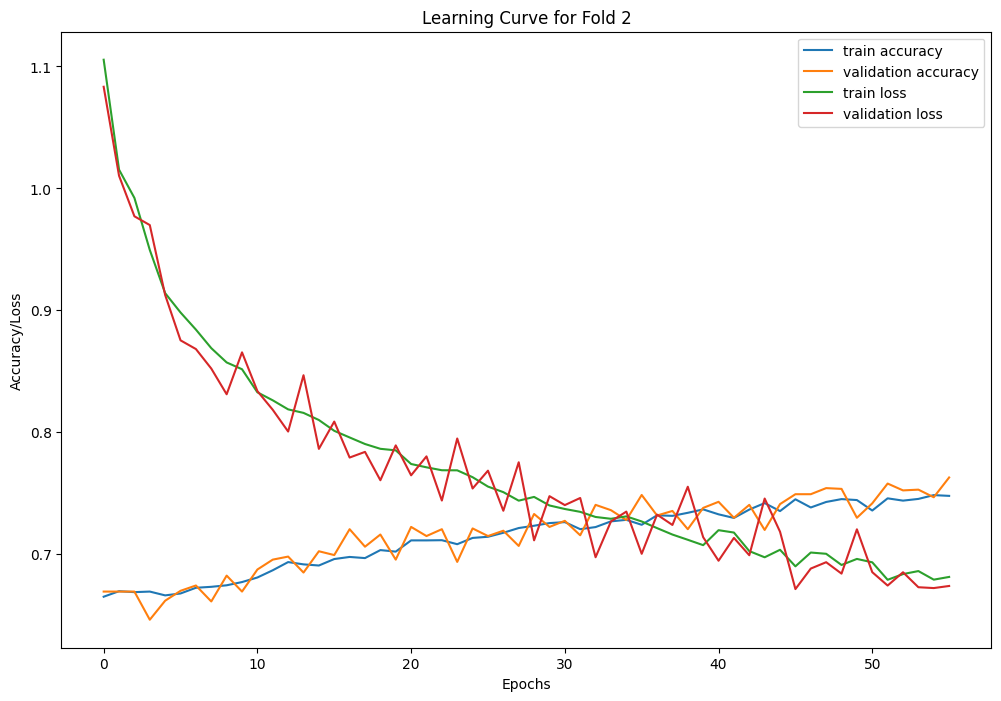

Fold 3
Epoch 1/200
401/401 [==============================] - 9s 19ms/step - loss: 1.1577 - acc: 0.6615 - val_loss: 1.0508 - val_acc: 0.6698


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
401/401 [==============================] - 6s 16ms/step - loss: 1.0379 - acc: 0.6690 - val_loss: 0.9751 - val_acc: 0.6698
Epoch 3/200
401/401 [==============================] - 8s 20ms/step - loss: 1.0010 - acc: 0.6691 - val_loss: 0.9396 - val_acc: 0.6698
Epoch 4/200
401/401 [==============================] - 6s 16ms/step - loss: 0.9641 - acc: 0.6682 - val_loss: 0.9182 - val_acc: 0.6654
Epoch 5/200
401/401 [==============================] - 9s 22ms/step - loss: 0.9331 - acc: 0.6672 - val_loss: 0.8920 - val_acc: 0.6735
Epoch 6/200
401/401 [==============================] - 6s 14ms/step - loss: 0.9126 - acc: 0.6666 - val_loss: 0.8628 - val_acc: 0.6748
Epoch 7/200
401/401 [==============================] - 6s 15ms/step - loss: 0.8854 - acc: 0.6739 - val_loss: 0.8380 - val_acc: 0.6710
Epoch 8/200
401/401 [==============================] - 7s 18ms/step - loss: 0.8830 - acc: 0.6764 - val_loss: 0.8686 - val_acc: 0.6517
Epoch 9/200
401/401 [==============================] - 6s 15ms

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


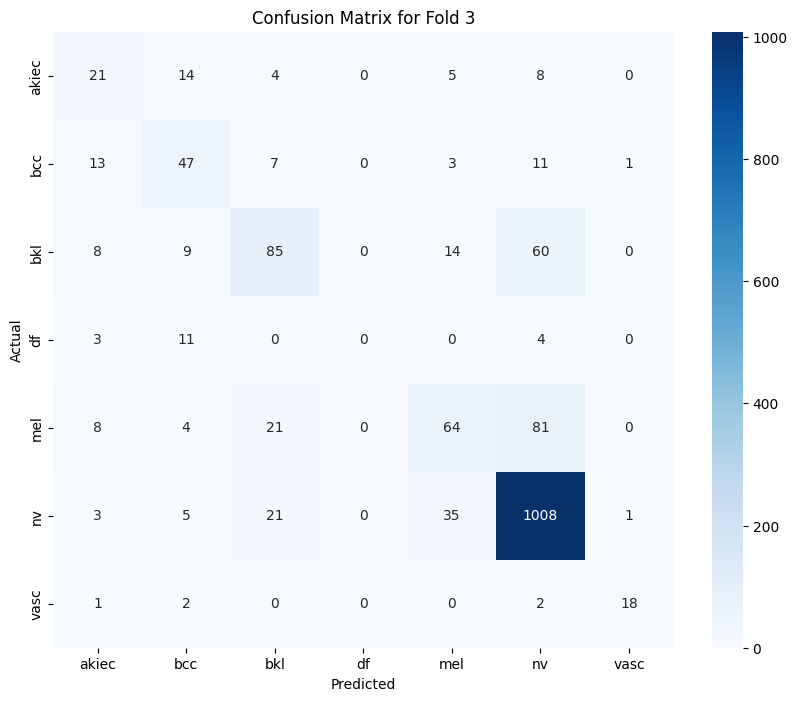

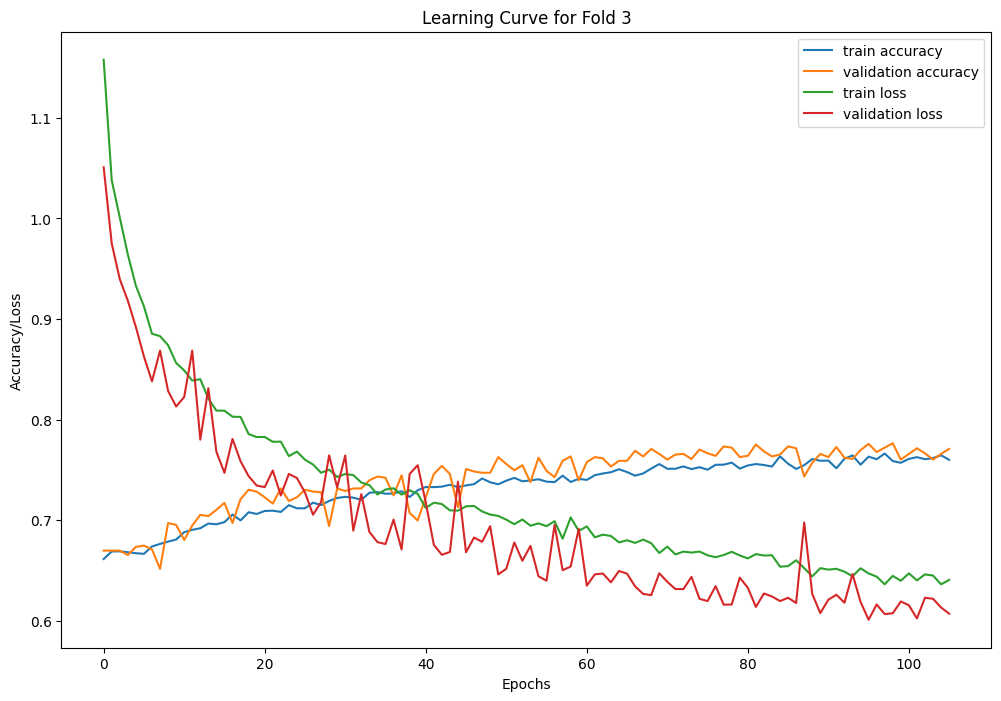

Fold 4
Epoch 1/200
401/401 [==============================] - 13s 27ms/step - loss: 1.1184 - acc: 0.6658 - val_loss: 1.0438 - val_acc: 0.6698
Epoch 2/200
  5/401 [..............................] - ETA: 5s - loss: 1.2386 - acc: 0.6000 

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - 12s 29ms/step - loss: 1.0254 - acc: 0.6699 - val_loss: 0.9809 - val_acc: 0.6698
Epoch 3/200
401/401 [==============================] - 12s 30ms/step - loss: 0.9968 - acc: 0.6691 - val_loss: 0.9637 - val_acc: 0.6698
Epoch 4/200
401/401 [==============================] - 10s 25ms/step - loss: 0.9527 - acc: 0.6690 - val_loss: 0.9159 - val_acc: 0.6673
Epoch 5/200
401/401 [==============================] - 8s 19ms/step - loss: 0.9175 - acc: 0.6705 - val_loss: 0.9136 - val_acc: 0.6698
Epoch 6/200
401/401 [==============================] - 10s 24ms/step - loss: 0.9011 - acc: 0.6677 - val_loss: 0.8654 - val_acc: 0.6698
Epoch 7/200
401/401 [==============================] - 6s 16ms/step - loss: 0.8877 - acc: 0.6730 - val_loss: 0.8834 - val_acc: 0.6723
Epoch 8/200
401/401 [==============================] - 9s 24ms/step - loss: 0.8718 - acc: 0.6735 - val_loss: 0.8537 - val_acc: 0.6829
Epoch 9/200
401/401 [==============================] - 6s 16ms/step - 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


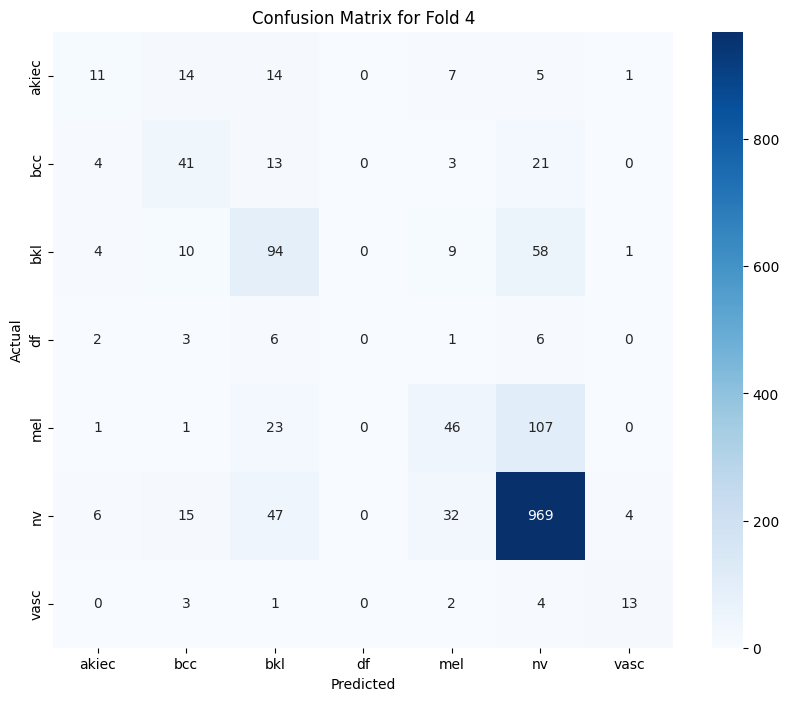

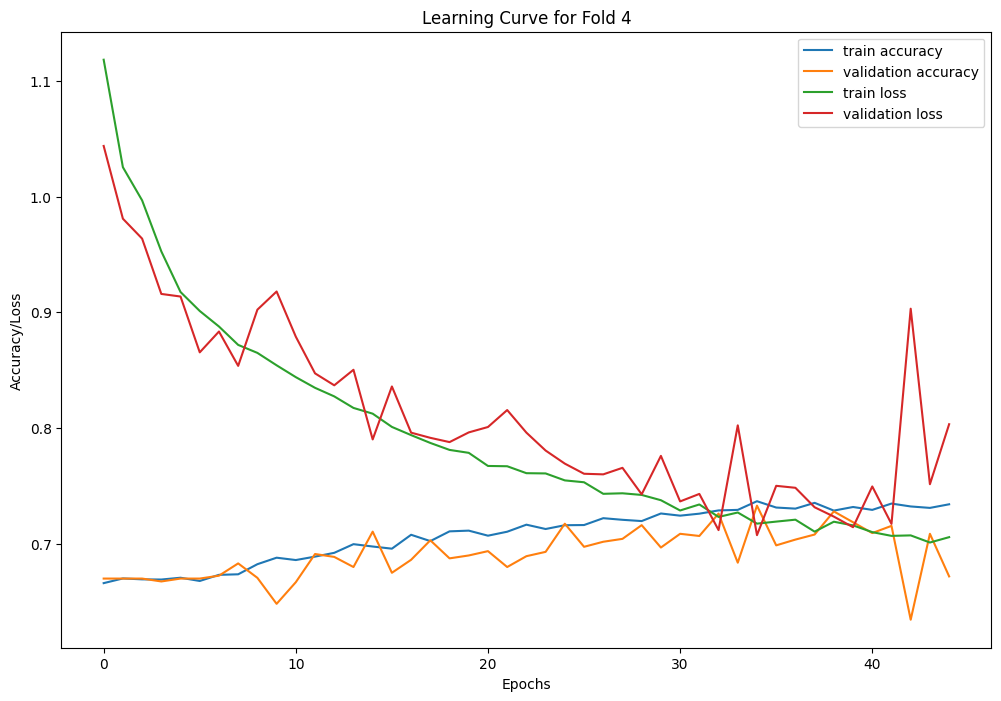

Fold 5
Epoch 1/200
401/401 [==============================] - 10s 22ms/step - loss: 1.1128 - acc: 0.6643 - val_loss: 1.0559 - val_acc: 0.6692
Epoch 2/200
  1/401 [..............................] - ETA: 21s - loss: 1.0836 - acc: 0.5625

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


401/401 [==============================] - 8s 19ms/step - loss: 1.0082 - acc: 0.6697 - val_loss: 0.9614 - val_acc: 0.6692
Epoch 3/200
401/401 [==============================] - 9s 23ms/step - loss: 0.9706 - acc: 0.6710 - val_loss: 0.9650 - val_acc: 0.6841
Epoch 4/200
401/401 [==============================] - 7s 17ms/step - loss: 0.9411 - acc: 0.6679 - val_loss: 0.9318 - val_acc: 0.6685
Epoch 5/200
401/401 [==============================] - 9s 23ms/step - loss: 0.9176 - acc: 0.6677 - val_loss: 0.8903 - val_acc: 0.6823
Epoch 6/200
401/401 [==============================] - 7s 18ms/step - loss: 0.8968 - acc: 0.6719 - val_loss: 0.8705 - val_acc: 0.6717
Epoch 7/200
401/401 [==============================] - 8s 20ms/step - loss: 0.8836 - acc: 0.6746 - val_loss: 0.8441 - val_acc: 0.6748
Epoch 8/200
401/401 [==============================] - 8s 21ms/step - loss: 0.8689 - acc: 0.6828 - val_loss: 0.8417 - val_acc: 0.6910
Epoch 9/200
401/401 [==============================] - 7s 17ms/step - loss

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


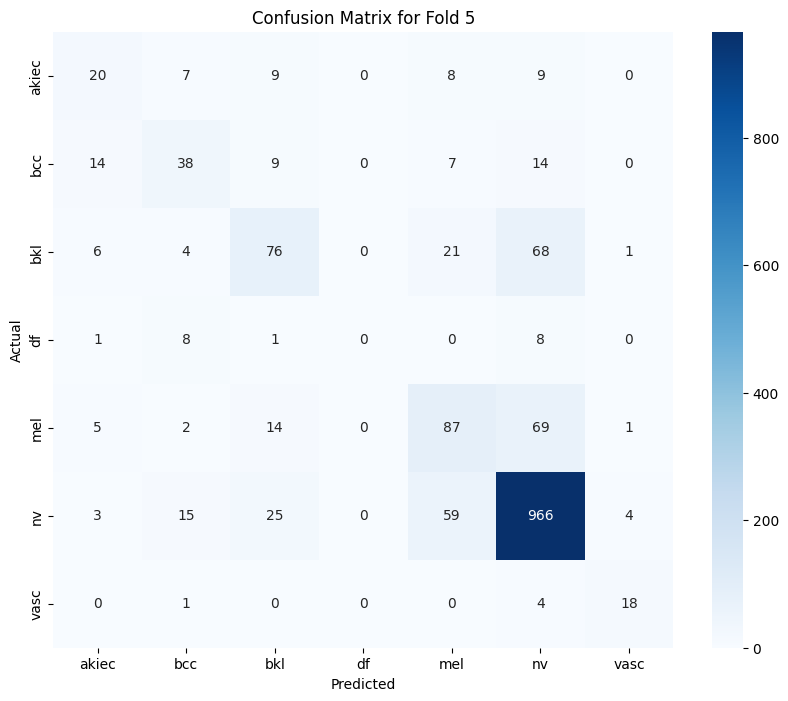

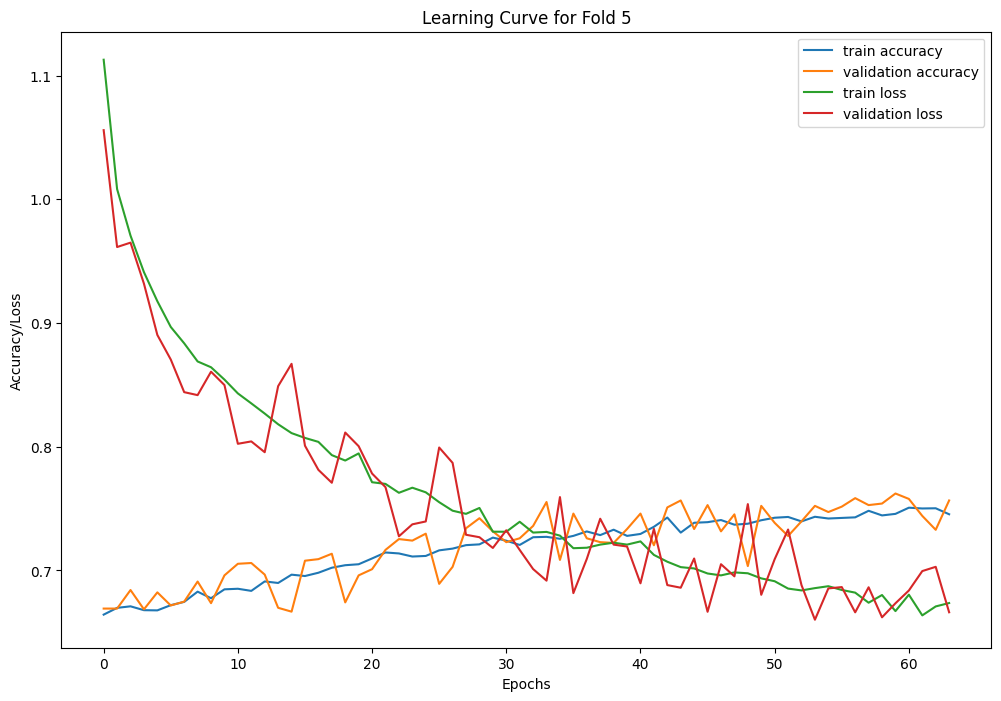

In [16]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
results = []
histories = []

for train_index, val_index in kf.split(X_train, np.argmax(Y_train, axis=1)):
    print(f"Fold {fold_no}")
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x_train_fold)

    model = create_model()

    # Callbacks
    checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/H10K-Dataset/SCDS2-best_model_fold_{fold_no}.h5', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(
        datagen.flow(x_train_fold, y_train_fold, batch_size=16),
        epochs=200,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[checkpoint, early_stopping],
    )
    histories.append(history)

    # Evaluation
    val_score = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Validation accuracy for fold {fold_no}: {val_score[1]}')
    results.append(val_score[1])

    # Predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true = np.argmax(y_val_fold, axis=1)

    # Classification Report
    print(f"Classification Report for Fold {fold_no}:")
    print(classification_report(y_test_true, y_test_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, y_test_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    # Plotting Learning Curves
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['acc'], label='train accuracy')
    plt.plot(history.history['val_acc'], label='validation accuracy')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title(f'Learning Curve for Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    plt.legend()
    plt.show()

    fold_no += 1

## Evaluation on Test Set

In [17]:
test_score = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_score[1]}')

Test accuracy: 0.7523714303970337


In [18]:
# Predictions
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(Y_test, axis=1)

# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=label_encoder.classes_))

63/63 [==============================] - 0s 2ms/step
Classification Report on Test Set:
              precision    recall  f1-score   support

       akiec       0.42      0.51      0.46        65
         bcc       0.53      0.50      0.51       103
         bkl       0.56      0.38      0.45       220
          df       0.00      0.00      0.00        23
         mel       0.45      0.42      0.43       223
          nv       0.85      0.92      0.88      1341
        vasc       0.67      0.50      0.57        28

    accuracy                           0.75      2003
   macro avg       0.50      0.46      0.47      2003
weighted avg       0.73      0.75      0.74      2003



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [20]:
# Calculate standard deviation and average accuracy
mean_accuracy = np.mean(results)
std_deviation = np.std(results)

print(f"Average validation accuracy: {mean_accuracy}")
print(f"Standard deviation of validation accuracy: {std_deviation}")

Average validation accuracy: 0.752247154712677
Standard deviation of validation accuracy: 0.013762794952116554


## Save final model

In [21]:
model.save('/content/drive/MyDrive/H10K-Dataset/SCDS2Net-H10K_Model-Final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predicting Image Labels

1/1 [==============================] - 0s 201ms/step
This image most likely belongs to nv class.


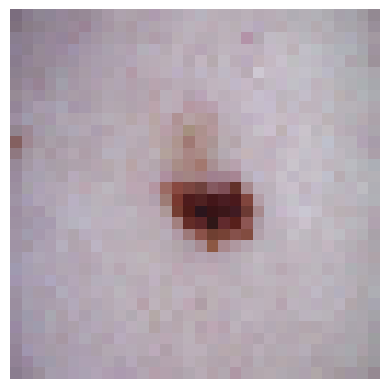

In [22]:
img_path = '/content/drive/MyDrive/H10K-Dataset/HAM10000_images_part_2/ISIC_0033561.jpg'
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("This image most likely belongs to {} class.".format(classes[np.argmax(score)]))

plt.imshow(img)
plt.axis('off')
plt.show()

‎

‎

‎

# Method 2 (Resample & Augment)

## K-Fold Cross Validation

Fold 1
Epoch 1/200
1878/1878 [==============================] - 34s 17ms/step - loss: 1.5550 - acc: 0.3720 - val_loss: 1.2343 - val_acc: 0.5041


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.2455 - acc: 0.5082 - val_loss: 1.1124 - val_acc: 0.5265
Epoch 3/200
1878/1878 [==============================] - 36s 19ms/step - loss: 1.1701 - acc: 0.5446 - val_loss: 1.0921 - val_acc: 0.5508
Epoch 4/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.1195 - acc: 0.5607 - val_loss: 1.0546 - val_acc: 0.5646
Epoch 5/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0652 - acc: 0.5831 - val_loss: 1.0780 - val_acc: 0.5565
Epoch 6/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0356 - acc: 0.5960 - val_loss: 1.0170 - val_acc: 0.5758
Epoch 7/200
1878/1878 [==============================] - 30s 16ms/step - loss: 0.9992 - acc: 0.6110 - val_loss: 0.9526 - val_acc: 0.6070
Epoch 8/200
1878/1878 [==============================] - 30s 16ms/step - loss: 0.9773 - acc: 0.6193 - val_loss: 0.9760 - val_acc: 0.6082
Epoch 9/200
1878/1878 [==================

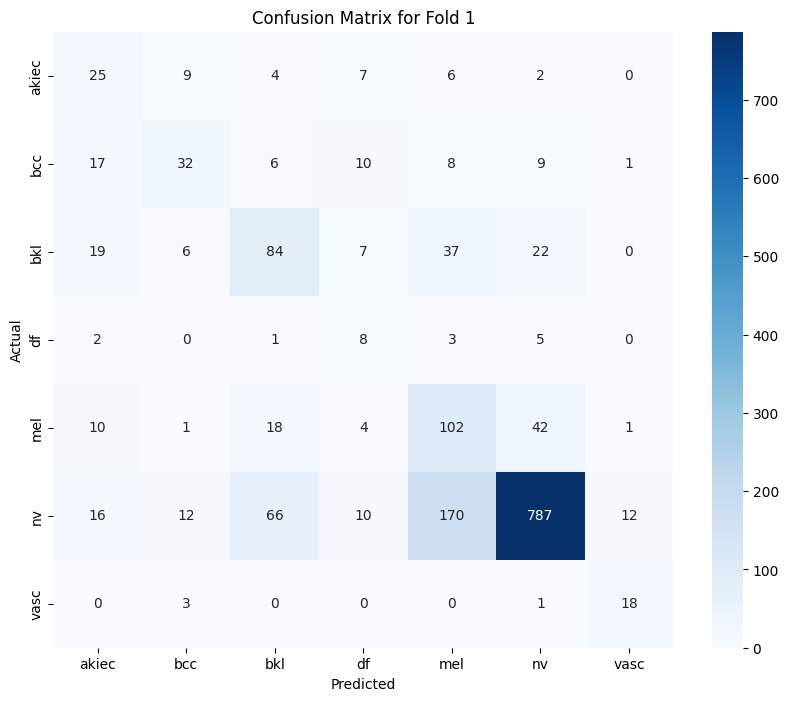

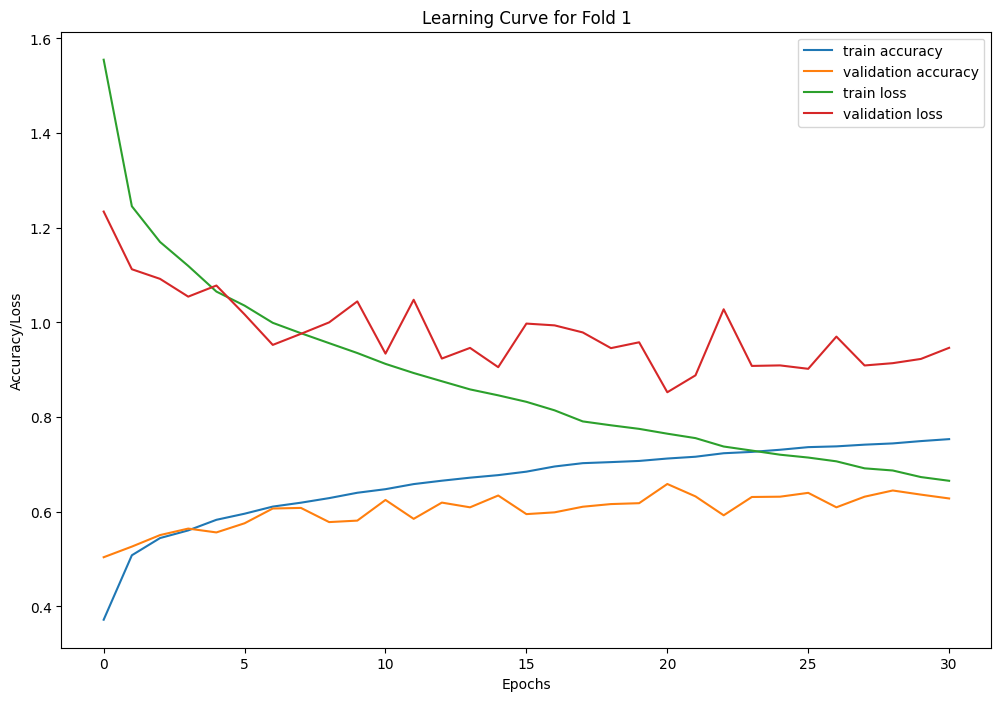

Fold 2
Epoch 1/200
1878/1878 [==============================] - 32s 16ms/step - loss: 1.6321 - acc: 0.3327 - val_loss: 1.2957 - val_acc: 0.4810
Epoch 2/200
   5/1878 [..............................] - ETA: 24s - loss: 1.5837 - acc: 0.4000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1878/1878 [==============================] - 31s 16ms/step - loss: 1.2964 - acc: 0.4955 - val_loss: 1.1023 - val_acc: 0.5396
Epoch 3/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.2064 - acc: 0.5350 - val_loss: 1.0878 - val_acc: 0.5502
Epoch 4/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.1396 - acc: 0.5604 - val_loss: 1.1835 - val_acc: 0.5134
Epoch 5/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0769 - acc: 0.5869 - val_loss: 1.1020 - val_acc: 0.5371
Epoch 6/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0374 - acc: 0.6032 - val_loss: 1.0592 - val_acc: 0.5602
Epoch 7/200
1878/1878 [==============================] - 31s 16ms/step - loss: 1.0070 - acc: 0.6111 - val_loss: 1.0268 - val_acc: 0.5758
Epoch 8/200
1878/1878 [==============================] - 31s 16ms/step - loss: 0.9770 - acc: 0.6273 - val_loss: 0.9283 - val_acc: 0.6107
Epoch 9/200
1878/1878 [==============================

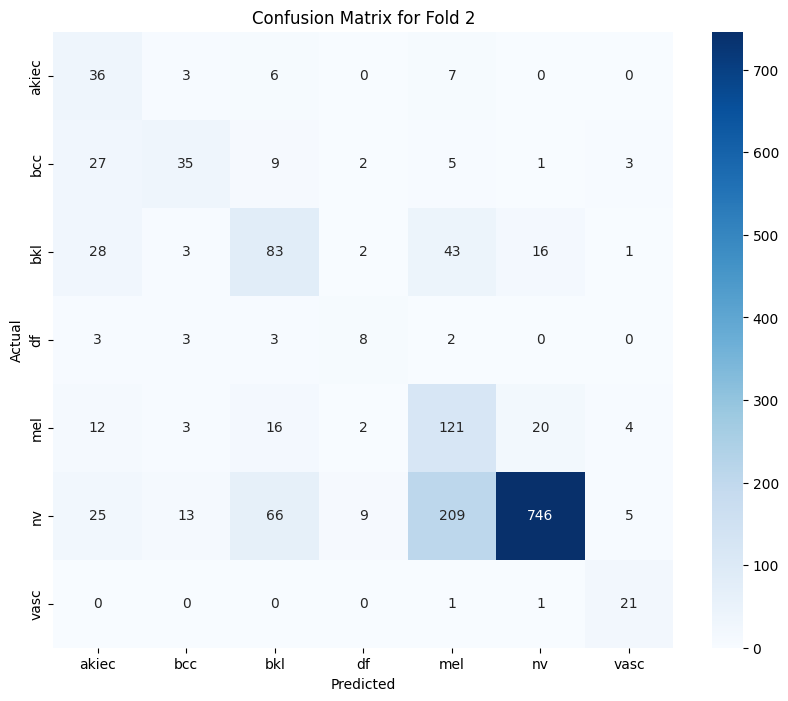

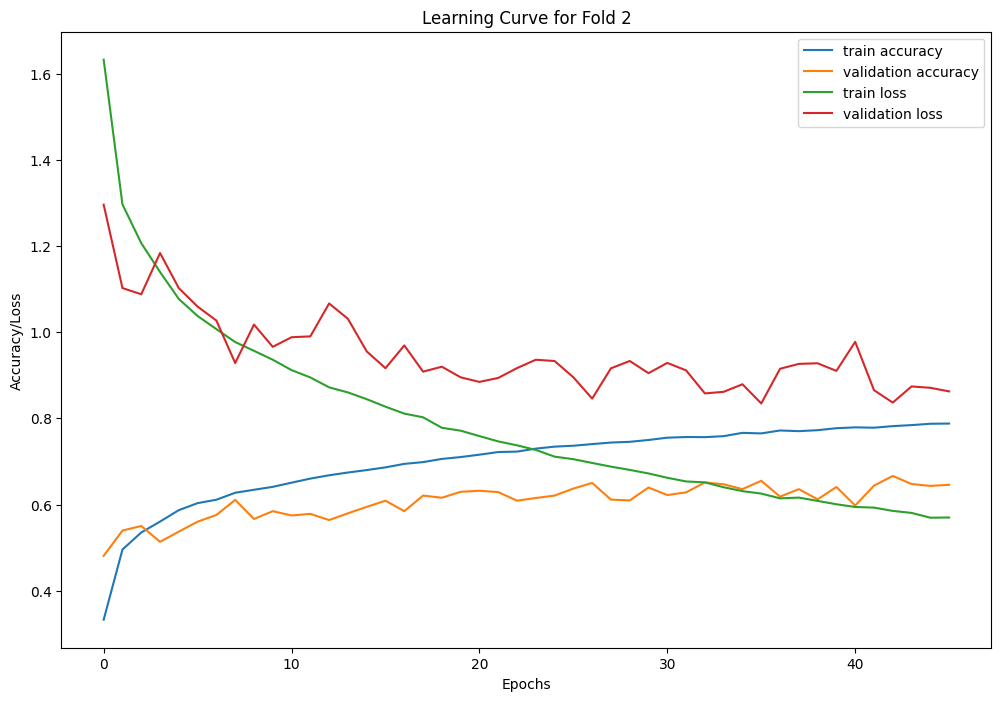

Fold 3
Epoch 1/200
1878/1878 [==============================] - 32s 16ms/step - loss: 1.6253 - acc: 0.3367 - val_loss: 1.0979 - val_acc: 0.5343


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.3031 - acc: 0.4859 - val_loss: 1.1259 - val_acc: 0.5381
Epoch 3/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.2182 - acc: 0.5271 - val_loss: 1.0087 - val_acc: 0.5705
Epoch 4/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.1611 - acc: 0.5509 - val_loss: 1.0336 - val_acc: 0.5655
Epoch 5/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.1105 - acc: 0.5698 - val_loss: 0.9476 - val_acc: 0.5968
Epoch 6/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0641 - acc: 0.5877 - val_loss: 0.9877 - val_acc: 0.5811
Epoch 7/200
1878/1878 [==============================] - 30s 16ms/step - loss: 1.0327 - acc: 0.6040 - val_loss: 0.9679 - val_acc: 0.5793
Epoch 8/200
1878/1878 [==============================] - 32s 17ms/step - loss: 1.0009 - acc: 0.6154 - val_loss: 1.0210 - val_acc: 0.5780
Epoch 9/200
1878/1878 [==================

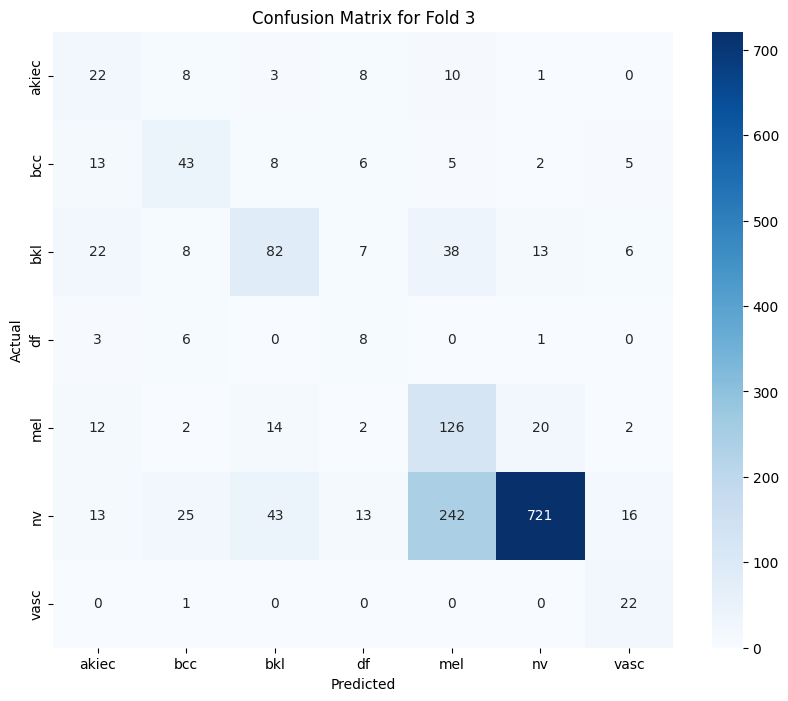

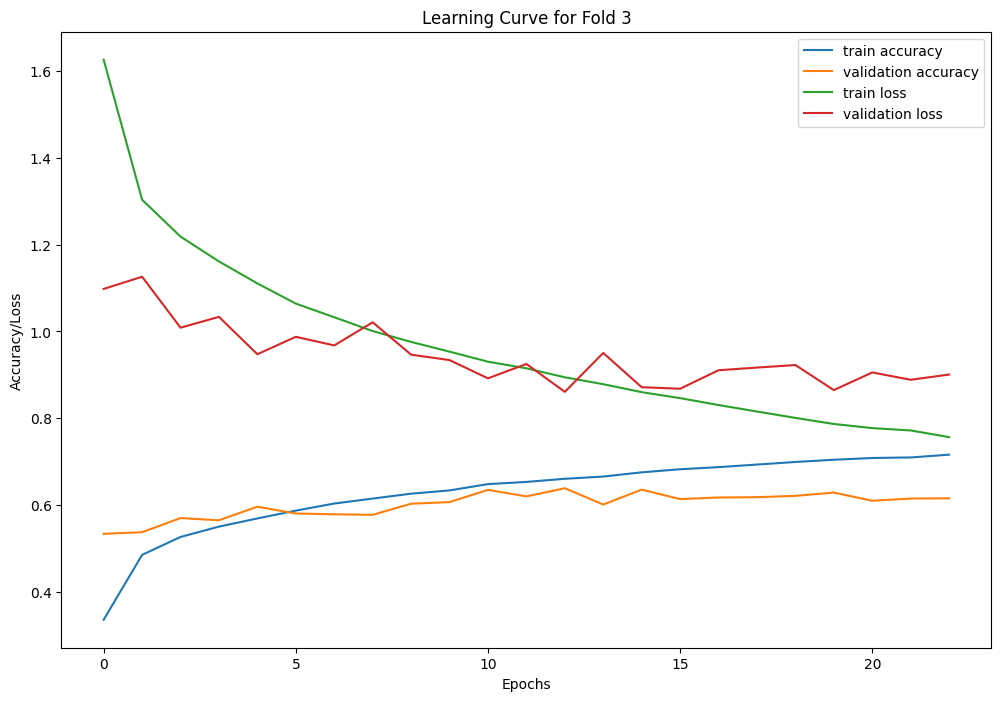

Fold 4
Epoch 1/200
1878/1878 [==============================] - 33s 17ms/step - loss: 1.6069 - acc: 0.3461 - val_loss: 1.1126 - val_acc: 0.5350
Epoch 2/200
   4/1878 [..............................] - ETA: 32s - loss: 1.3595 - acc: 0.5000

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1878/1878 [==============================] - 31s 17ms/step - loss: 1.2493 - acc: 0.5102 - val_loss: 1.1208 - val_acc: 0.5387
Epoch 3/200
1878/1878 [==============================] - 31s 16ms/step - loss: 1.1674 - acc: 0.5470 - val_loss: 1.0136 - val_acc: 0.5762
Epoch 4/200
1878/1878 [==============================] - 31s 16ms/step - loss: 1.1081 - acc: 0.5688 - val_loss: 1.0284 - val_acc: 0.5849
Epoch 5/200
1878/1878 [==============================] - 32s 17ms/step - loss: 1.0668 - acc: 0.5834 - val_loss: 0.9805 - val_acc: 0.5849
Epoch 6/200
1878/1878 [==============================] - 32s 17ms/step - loss: 1.0230 - acc: 0.6028 - val_loss: 1.0573 - val_acc: 0.5793
Epoch 7/200
1878/1878 [==============================] - 32s 17ms/step - loss: 0.9978 - acc: 0.6139 - val_loss: 1.0235 - val_acc: 0.5705
Epoch 8/200
1878/1878 [==============================] - 32s 17ms/step - loss: 0.9791 - acc: 0.6246 - val_loss: 1.0304 - val_acc: 0.5737
Epoch 9/200
1878/1878 [==============================

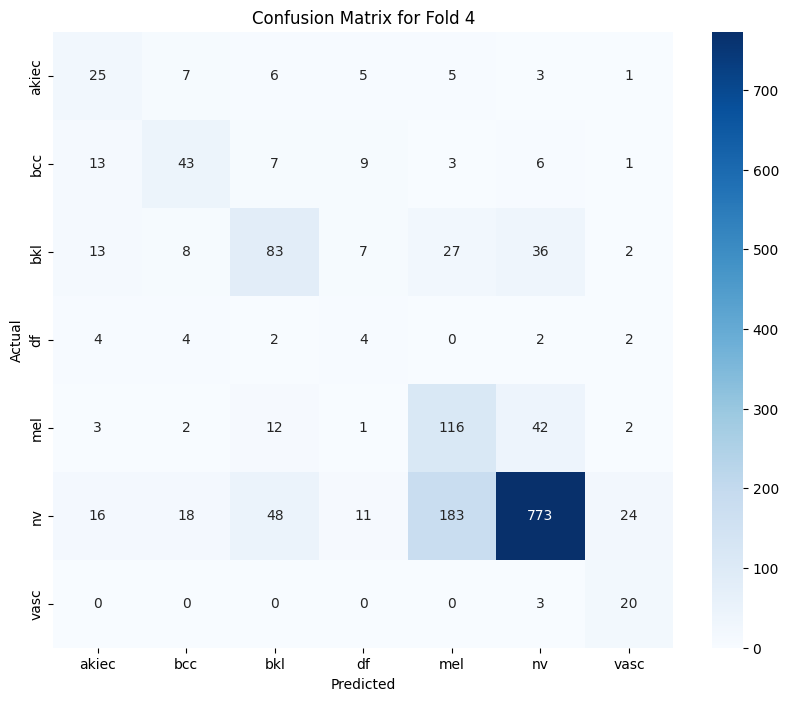

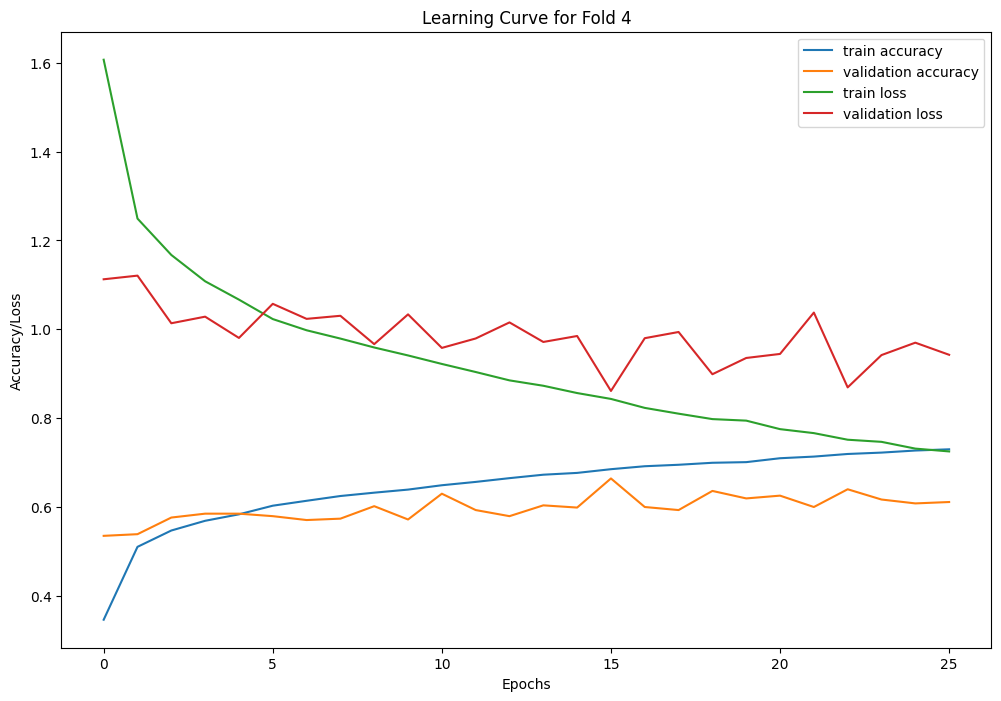

Fold 5
Epoch 1/200
1878/1878 [==============================] - 36s 18ms/step - loss: 1.6744 - acc: 0.3238 - val_loss: 1.1636 - val_acc: 0.5243
Epoch 2/200
   1/1878 [..............................] - ETA: 1:52 - loss: 1.6613 - acc: 0.2500

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1878/1878 [==============================] - 34s 18ms/step - loss: 1.3113 - acc: 0.4904 - val_loss: 1.2400 - val_acc: 0.4944
Epoch 3/200
1878/1878 [==============================] - 35s 19ms/step - loss: 1.2185 - acc: 0.5290 - val_loss: 1.0633 - val_acc: 0.5818
Epoch 4/200
1878/1878 [==============================] - 37s 20ms/step - loss: 1.1523 - acc: 0.5572 - val_loss: 1.1744 - val_acc: 0.5275
Epoch 5/200
1878/1878 [==============================] - 34s 18ms/step - loss: 1.0972 - acc: 0.5764 - val_loss: 1.1350 - val_acc: 0.5431
Epoch 6/200
1878/1878 [==============================] - 35s 18ms/step - loss: 1.0639 - acc: 0.5923 - val_loss: 1.0681 - val_acc: 0.5506
Epoch 7/200
1878/1878 [==============================] - 35s 19ms/step - loss: 1.0310 - acc: 0.6053 - val_loss: 0.9529 - val_acc: 0.6061
Epoch 8/200
1878/1878 [==============================] - 34s 18ms/step - loss: 0.9961 - acc: 0.6184 - val_loss: 0.9737 - val_acc: 0.5924
Epoch 9/200
1878/1878 [==============================

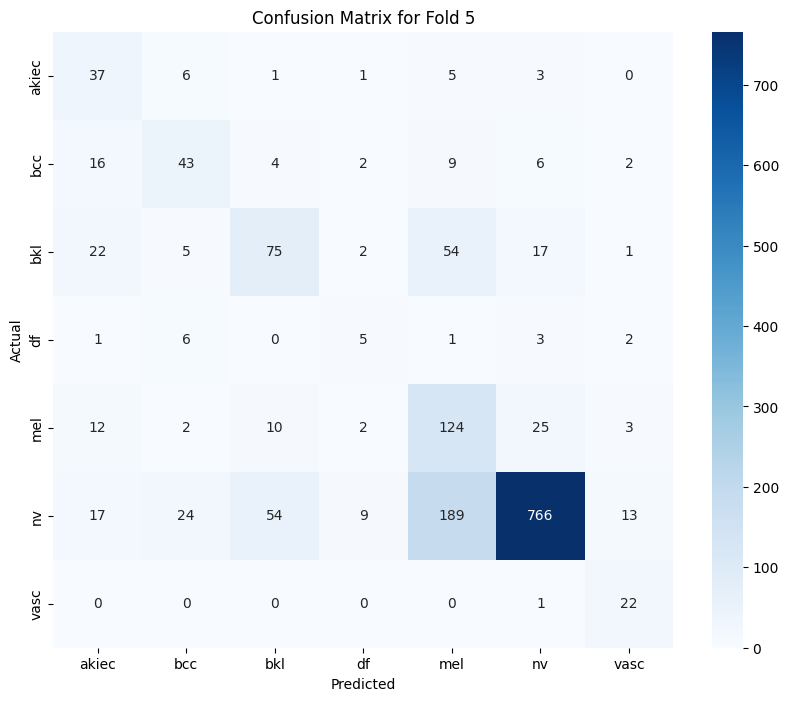

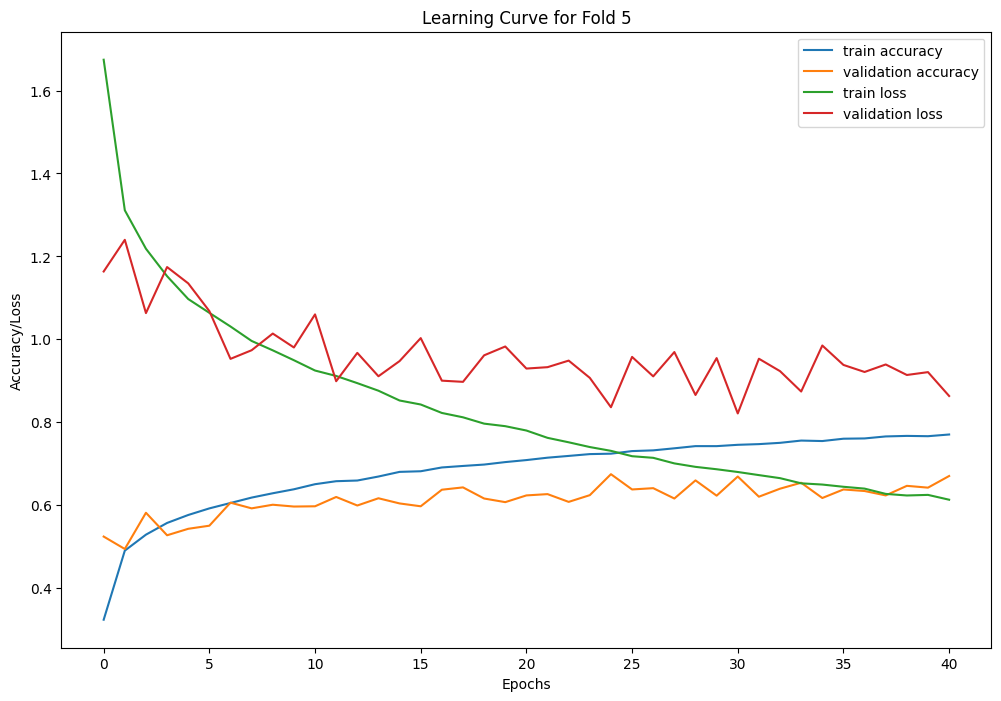

In [24]:
kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
fold_no = 1
results = []
histories = []

for train_index, val_index in kf.split(X_train, np.argmax(Y_train, axis=1)):
    print(f"Fold {fold_no}")
    x_train_fold, x_val_fold = X_train[train_index], X_train[val_index]
    y_train_fold, y_val_fold = Y_train[train_index], Y_train[val_index]

    # Reshape the data to 2D for SMOTE
    x_train_fold_flat = x_train_fold.reshape((x_train_fold.shape[0], -1))
    smote = SMOTE(random_state=42)
    x_train_fold_res, y_train_fold_res = smote.fit_resample(x_train_fold_flat, np.argmax(y_train_fold, axis=1))

    # Reshape back to 4D
    x_train_fold_res = x_train_fold_res.reshape((-1, IMG_SIZE, IMG_SIZE, 3))
    y_train_fold_res = to_categorical(y_train_fold_res, num_classes=7)

    # Data Augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True
    )
    datagen.fit(x_train_fold_res)

    model = create_model()

    # Callbacks
    checkpoint = ModelCheckpoint(f'/content/drive/MyDrive/H10K-Dataset/SCDS3-best_model_fold_{fold_no}.h5', monitor='val_loss', save_best_only=True, mode='min')
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')

    history = model.fit(
        datagen.flow(x_train_fold_res, y_train_fold_res, batch_size=16),
        epochs=200,
        validation_data=(x_val_fold, y_val_fold),
        callbacks=[checkpoint, early_stopping],
    )
    histories.append(history)

    # Evaluation
    val_score = model.evaluate(X_test, Y_test, verbose=0)
    print(f'Validation accuracy for fold {fold_no}: {val_score[1]}')
    results.append(val_score[1])

    # Predictions
    y_test_pred = model.predict(X_test)
    y_test_pred_classes = np.argmax(y_test_pred, axis=1)
    y_test_true = np.argmax(y_val_fold, axis=1)

    # Classification Report
    print(f"Classification Report for Fold {fold_no}:")
    print(classification_report(y_test_true, y_test_pred_classes, target_names=label_encoder.classes_))

    # Confusion Matrix
    cm = confusion_matrix(y_test_true, y_test_pred_classes)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'Confusion Matrix for Fold {fold_no}')
    plt.show()

    # Plotting Learning Curves
    plt.figure(figsize=(12, 8))
    plt.plot(history.history['acc'], label='train accuracy')
    plt.plot(history.history['val_acc'], label='validation accuracy')
    plt.plot(history.history['loss'], label='train loss')
    plt.plot(history.history['val_loss'], label='validation loss')
    plt.title(f'Learning Curve for Fold {fold_no}')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy/Loss')
    plt.legend()
    plt.show()

    fold_no += 1

## Evaluation on Test Set

In [25]:
test_score = model.evaluate(X_test, Y_test, verbose=0)
print(f'Test accuracy: {test_score[1]}')

Test accuracy: 0.6879680752754211


In [26]:
# Predictions
y_test_pred = model.predict(X_test)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
y_test_true = np.argmax(Y_test, axis=1)

63/63 [==============================] - 0s 4ms/step


In [27]:
# Classification Report
print("Classification Report on Test Set:")
print(classification_report(y_test_true, y_test_pred_classes, target_names=label_encoder.classes_))

Classification Report on Test Set:
              precision    recall  f1-score   support

       akiec       0.38      0.72      0.50        65
         bcc       0.54      0.48      0.51       103
         bkl       0.60      0.40      0.48       220
          df       0.36      0.39      0.37        23
         mel       0.32      0.67      0.43       223
          nv       0.92      0.75      0.83      1341
        vasc       0.47      0.93      0.63        28

    accuracy                           0.69      2003
   macro avg       0.51      0.62      0.54      2003
weighted avg       0.77      0.69      0.71      2003



In [29]:
# Calculate standard deviation and average accuracy
mean_accuracy = np.mean(results)
std_deviation = np.std(results)

print(f"Average validation accuracy: {mean_accuracy}")
print(f"Standard deviation of validation accuracy: {std_deviation}")

Average validation accuracy: 0.6572641968727112
Standard deviation of validation accuracy: 0.010225858175793301


## Save final model

In [30]:
model.save('/content/drive/MyDrive/H10K-Dataset/SCDS3Net-H10K_Model-Final.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Predicting Image Labels

1/1 [==============================] - 0s 31ms/step
This image most likely belongs to nv class.


<function matplotlib.pyplot.axis(arg=None, /, *, emit=True, **kwargs)>

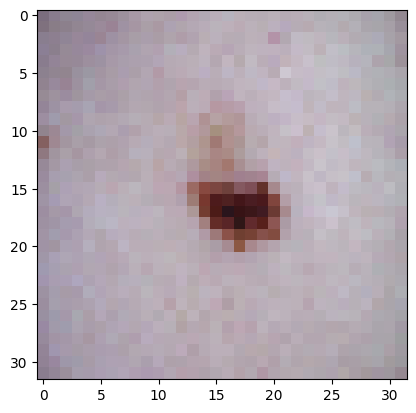

In [31]:
img_path = '/content/drive/MyDrive/H10K-Dataset/HAM10000_images_part_2/ISIC_0033561.jpg'
img = image.load_img(img_path, target_size=(32, 32))
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

classes = ['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']
print("This image most likely belongs to {} class.".format(classes[np.argmax(score)]))

plt.imshow(img)
plt.axis